# Ideation

The 2018/2019 data somewhat correlated to the 2020 fantasy results, but the model is still fairly inaccurate.

In this exploration, I will add additional data to the model and explore its impacts. When looking at 2020 data, the key is to look for data from before the season started, as that's the same situation we're in for 2021. Potential data:
* Strength of schedule (starting team-wise and then expanding position wise)
* Strength of schedule, but looking at fantasy points allowed per position rather than raw schedule (end of previous season stats)
* Strength of teammates in other positions (since we're doing QBs, we'll look at overall OL rankings. May also want to look at RBs as they'll take snaps from QB)
* Strength of teammates in same position (less so a factor for QBs, but for RBs snap splitting is an issue) 
* Pre-season power rankings (to account for trades and other such factors that improve teams YoY)
* Player age / injury history



In [ ]:
!pip install scikit-optimize


# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mpl_toolkits
from functools import reduce
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

%matplotlib inline

You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
short_form_to_team_name = {"GB": "Packers", "HOU": "Texans", "KC": "Chiefs", "BUF": "Bills", "TEN": "Titans", "NO": "Saints", \
 "SEA": "Seahawks", "MIN": "Vikings", "TB": "Buccaneers", "LV": "Raiders", "BAL": "Ravens", "LAC": "Chargers", "IND": "Colts", \
 "DET": "Lions", "CLE": "Browns", "JAX": "Jaguars", "MIA": "Dolphins", "ARI": "Cardinals", "PIT": "Steelers", "CHI": "Bears", \
 "ATL": "Falcons", "CAR": "Panthers", "LA": "Rams", "CIN": "Bengals", "DAL": "Cowboys", "SF": "49ers", "NYG": "Giants", \
 "WAS": "Redskins", "DEN": "Broncos", "PHI": "Eagles", "NYJ": "Jets", "NE": "Patriots"}

team_name_to_short_form = {value: key for key, value in short_form_to_team_name.items()}

len(team_name_to_short_form)

32

In [ ]:
# Get data
stats_2020 = pd.read_csv("FF_2021/qb/2020.csv", thousands=',')
stats_2019 = pd.read_csv("FF_2021/qb/2019.csv", thousands=',')
stats_2018 = pd.read_csv("FF_2021/qb/2018.csv", thousands=',')
teams_2020 = pd.read_csv("FF_2021/qb/2020_player_team.csv")
teams_2019 = pd.read_csv("FF_2021/qb/2019_player_team.csv")
#sos = pd.read_csv("FF_2021/2019_2020_sos.csv")
sos_2020 = pd.read_csv("FF_2021/2020_sos.csv")
sos_2019 = pd.read_csv("FF_2021/2019_sos.csv")

madden_2018 = pd.read_csv("FF_2021/madden_18_19.csv")
madden_2019 = pd.read_csv("FF_2021/madden_19_20.csv")
madden_2020 = pd.read_csv("FF_2021/madden_20_21.csv")

qb_data_years = [stats_2020, stats_2019, stats_2018]
madden_ratings = [madden_2018, madden_2019, madden_2020]

# Clean/Merge all the data

year = 2020

# Clean up duplicate columns
# Drop columns that are likely not important based on football knowledge
for i in range(len(qb_data_years)):
    qb_data_years[i] = qb_data_years[i] \
        .rename(columns={"Pts*" : "Pts", "Att": "Pass_Att", "Yds": "Pass_Yds", "TD": "Pass_TD","Att.1": "Rush_Att", "Yds.1": "Rush_Yds", "TD.1": "Rush_TD"}) \
        .drop(columns=["Bye", "2Pt", "2Pt.1", "Rec", "Yds.2", "TD.2", "2Pt.2", "TD.3"])

    column_names = qb_data_years[i].columns.delete(0)
    for column in column_names:
        qb_data_years[i][column] = qb_data_years[i][column].astype(float)
        qb_data_years[i] = qb_data_years[i].rename(columns={column: column + "_" + str(year)})

    year -= 1

merged = reduce(lambda left,right: pd.merge(left,right, on=['Player'], how="outer"), qb_data_years).fillna(0)
# Drop all 2020 columns except points, as those will throw off the testing
merged = merged.drop(columns=["Pass_Att_2020", "Cmp_2020", "Pass_Yds_2020", "Pass_TD_2020", "Int_2020", "Rush_Att_2020", "Rush_Yds_2020", "Rush_TD_2020", "FL_2020"])
merged

,Player,Pts_2020,Pts_2019,Pass_Att_2019,Cmp_2019,Pass_Yds_2019,Pass_TD_2019,Int_2019,Rush_Att_2019,Rush_Yds_2019,...,Pts_2018,Pass_Att_2018,Cmp_2018,Pass_Yds_2018,Pass_TD_2018,Int_2018,Rush_Att_2018,Rush_Yds_2018,Rush_TD_2018,FL_2018
0,Aaron Rodgers,469.0,322.0,569.0,353.0,4002.0,26.0,4.0,46.0,183.0,...,352.0,597.0,372.0,4442.0,25.0,2.0,43.0,269.0,2.0,3.0
1,Josh Allen,461.0,318.0,461.0,271.0,3089.0,20.0,9.0,109.0,510.0,...,218.0,320.0,169.0,2074.0,10.0,12.0,89.0,631.0,8.0,2.0
2,Patrick Mahomes,439.0,329.0,484.0,319.0,4031.0,26.0,5.0,43.0,218.0,...,507.0,580.0,383.0,5097.0,50.0,12.0,60.0,272.0,2.0,2.0
3,Russell Wilson,428.0,379.0,516.0,341.0,4110.0,31.0,5.0,75.0,342.0,...,359.0,427.0,280.0,3448.0,35.0,7.0,67.0,376.0,0.0,2.0
4,Deshaun Watson,421.0,364.0,495.0,333.0,3852.0,26.0,12.0,82.0,413.0,...,374.0,505.0,345.0,4165.0,26.0,9.0,99.0,551.0,5.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,Brandon Weeden,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0
104,Chad Kelly,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,0.0
105,Matt Cassel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,17.0,7.0,59.0,0.0,1.0,2.0,13.0,0.0,0.0
106,Mark Sanchez,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,35.0,19.0,138.0,0.0,3.0,1.0,8.0,0.0,0.0


In [ ]:
# Add in SoS

merged = pd.merge(merged, teams_2019, how="outer").dropna()
merged = merged.rename(columns={"Team" : "Team_2019"})
merged = pd.merge(merged, teams_2020, how="outer").dropna()
merged = merged.rename(columns={"Team" : "Team_2020"})

merged = pd.merge(merged, sos_2019, how="left").dropna()
merged = pd.merge(merged, sos_2020, how="left").dropna()

merged = merged.drop(columns=["Team_2019"])


merged

,Player,Pts_2020,Pts_2019,Pass_Att_2019,Cmp_2019,Pass_Yds_2019,Pass_TD_2019,Int_2019,Rush_Att_2019,Rush_Yds_2019,...,Pass_Yds_2018,Pass_TD_2018,Int_2018,Rush_Att_2018,Rush_Yds_2018,Rush_TD_2018,FL_2018,Team_2020,Sos_2019,Sos_2020
0,Aaron Rodgers,469.0,322.0,569.0,353.0,4002.0,26.0,4.0,46.0,183.0,...,4442.0,25.0,2.0,43.0,269.0,2.0,3.0,GB,0.500,0.500
1,Josh Allen,461.0,318.0,461.0,271.0,3089.0,20.0,9.0,109.0,510.0,...,2074.0,10.0,12.0,89.0,631.0,8.0,2.0,BUF,0.477,0.523
2,Patrick Mahomes,439.0,329.0,484.0,319.0,4031.0,26.0,5.0,43.0,218.0,...,5097.0,50.0,12.0,60.0,272.0,2.0,2.0,KC,0.516,0.500
3,Russell Wilson,428.0,379.0,516.0,341.0,4110.0,31.0,5.0,75.0,342.0,...,3448.0,35.0,7.0,67.0,376.0,0.0,2.0,SEA,0.473,0.504
4,Deshaun Watson,421.0,364.0,495.0,333.0,3852.0,26.0,12.0,82.0,413.0,...,4165.0,26.0,9.0,99.0,551.0,5.0,3.0,HOU,0.527,0.516
5,Kyler Murray,418.0,311.0,542.0,349.0,3722.0,20.0,12.0,93.0,544.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ARI,0.504,0.516
6,Tom Brady,408.0,304.0,613.0,373.0,4057.0,24.0,8.0,26.0,34.0,...,4355.0,29.0,11.0,23.0,35.0,2.0,2.0,TB,0.469,0.500
7,Ryan Tannehill,395.0,261.0,286.0,201.0,2742.0,22.0,6.0,43.0,185.0,...,1979.0,17.0,9.0,32.0,145.0,0.0,4.0,TEN,0.512,0.496
8,Lamar Jackson,375.0,474.0,401.0,265.0,3127.0,36.0,6.0,176.0,1206.0,...,1201.0,6.0,3.0,147.0,695.0,5.0,4.0,BAL,0.488,0.438
9,Kirk Cousins,370.0,288.0,444.0,307.0,3603.0,26.0,6.0,31.0,63.0,...,4298.0,30.0,10.0,44.0,123.0,1.0,7.0,MIN,0.508,0.512


In [ ]:
#https://maddenratings.weebly.com/madden-nfl-21.html

combined_madden = reduce(lambda left,right: pd.merge(left,right, on=['Player'], how="outer"), madden_ratings).fillna(0)
merged_with_madden = pd.merge(merged, combined_madden, how="left").fillna(0)
merged_with_madden



,Player,Pts_2020,Pts_2019,Pass_Att_2019,Cmp_2019,Pass_Yds_2019,Pass_TD_2019,Int_2019,Rush_Att_2019,Rush_Yds_2019,...,Sos_2020,Age_2018,2018_Overall,2018_Injury,2019_Overall,2019_Injury,2019_Age,2020_Overall,2020_Age,2020_Injury
0,Aaron Rodgers,469.0,322.0,569.0,353.0,4002.0,26.0,4.0,46.0,183.0,...,0.500,34.0,99.0,95.0,90.0,90.0,35.0,89.0,36.0,90.0
1,Josh Allen,461.0,318.0,461.0,271.0,3089.0,20.0,9.0,109.0,510.0,...,0.523,22.0,74.0,87.0,74.0,87.0,23.0,77.0,24.0,87.0
2,Patrick Mahomes,439.0,329.0,484.0,319.0,4031.0,26.0,5.0,43.0,218.0,...,0.500,0.0,0.0,0.0,97.0,94.0,23.0,99.0,24.0,95.0
3,Russell Wilson,428.0,379.0,516.0,341.0,4110.0,31.0,5.0,75.0,342.0,...,0.504,29.0,92.0,97.0,91.0,98.0,30.0,97.0,31.0,98.0
4,Deshaun Watson,421.0,364.0,495.0,333.0,3852.0,26.0,12.0,82.0,413.0,...,0.516,22.0,82.0,89.0,82.0,89.0,23.0,86.0,24.0,89.0
5,Kyler Murray,418.0,311.0,542.0,349.0,3722.0,20.0,12.0,93.0,544.0,...,0.516,0.0,0.0,0.0,73.0,88.0,22.0,77.0,23.0,88.0
6,Tom Brady,408.0,304.0,613.0,373.0,4057.0,24.0,8.0,26.0,34.0,...,0.500,41.0,99.0,98.0,96.0,99.0,42.0,90.0,43.0,99.0
7,Ryan Tannehill,395.0,261.0,286.0,201.0,2742.0,22.0,6.0,43.0,185.0,...,0.496,30.0,78.0,88.0,74.0,86.0,31.0,80.0,32.0,86.0
8,Lamar Jackson,375.0,474.0,401.0,265.0,3127.0,36.0,6.0,176.0,1206.0,...,0.438,21.0,79.0,90.0,76.0,92.0,22.0,94.0,23.0,92.0
9,Kirk Cousins,370.0,288.0,444.0,307.0,3603.0,26.0,6.0,31.0,63.0,...,0.512,30.0,82.0,88.0,81.0,88.0,31.0,82.0,32.0,88.0


In [ ]:
# LT, LG, C, RG, RT
ol_positions = ["LT", "LG", "C", "RG", "RT"]
ol_2020 = pd.read_csv("FF_2021/2020_player_team_full.csv")
ol_2020 = ol_2020[ol_2020.Position_2020.isin(ol_positions)].replace({"Team_2020": team_name_to_short_form})
ol_2020

ol_2020_rankings = pd.merge(ol_2020, madden_2020, on=['Player'], how="left").drop(columns=["2020_Age", "2020_Injury"]).rename(columns={"2020_Overall": "Overall_2020"})

# Determine strength of team -> focus on just the starters and then give half points to the backups

# Iteration in pandas is slow, but this is only 419 rows. Can be optimized in the future
#for row in ol_2021_rankings.itertuples():
#    print(row)

ol_2020_rankings = ol_2020_rankings.groupby(['Team_2020']).head(7).reset_index(drop=True)
ol_2020_overall = ol_2020_rankings.groupby(['Team_2020']).mean()
ol_2020_overall


,Overall_2020
Team_2020,
ARI,71.571429
ATL,72.714286
BAL,75.714286
BUF,74.714286
CAR,72.428571
CHI,72.000000
CIN,66.571429
CLE,74.285714
DAL,79.714286


In [ ]:
ol_2020_overall = pd.read_csv("FF_2021/ol_2020_overall.csv")
merged_with_madden = merged_with_madden.rename(columns={"Team_2020" : "Team"})
merged_with_madden_and_ol = pd.merge(merged_with_madden, ol_2020_overall, on=['Team'], how="left").drop(columns=["Team"])
merged_with_madden_and_ol


,Player,Pts_2020,Pts_2019,Pass_Att_2019,Cmp_2019,Pass_Yds_2019,Pass_TD_2019,Int_2019,Rush_Att_2019,Rush_Yds_2019,...,Age_2018,2018_Overall,2018_Injury,2019_Overall,2019_Injury,2019_Age,2020_Overall,2020_Age,2020_Injury,Ol_2020
0,Aaron Rodgers,469.0,322.0,569.0,353.0,4002.0,26.0,4.0,46.0,183.0,...,34.0,99.0,95.0,90.0,90.0,35.0,89.0,36.0,90.0,74.714286
1,Josh Allen,461.0,318.0,461.0,271.0,3089.0,20.0,9.0,109.0,510.0,...,22.0,74.0,87.0,74.0,87.0,23.0,77.0,24.0,87.0,74.714286
2,Patrick Mahomes,439.0,329.0,484.0,319.0,4031.0,26.0,5.0,43.0,218.0,...,0.0,0.0,0.0,97.0,94.0,23.0,99.0,24.0,95.0,73.714286
3,Russell Wilson,428.0,379.0,516.0,341.0,4110.0,31.0,5.0,75.0,342.0,...,29.0,92.0,97.0,91.0,98.0,30.0,97.0,31.0,98.0,69.000000
4,Deshaun Watson,421.0,364.0,495.0,333.0,3852.0,26.0,12.0,82.0,413.0,...,22.0,82.0,89.0,82.0,89.0,23.0,86.0,24.0,89.0,71.000000
5,Kyler Murray,418.0,311.0,542.0,349.0,3722.0,20.0,12.0,93.0,544.0,...,0.0,0.0,0.0,73.0,88.0,22.0,77.0,23.0,88.0,71.571429
6,Tom Brady,408.0,304.0,613.0,373.0,4057.0,24.0,8.0,26.0,34.0,...,41.0,99.0,98.0,96.0,99.0,42.0,90.0,43.0,99.0,72.142857
7,Ryan Tannehill,395.0,261.0,286.0,201.0,2742.0,22.0,6.0,43.0,185.0,...,30.0,78.0,88.0,74.0,86.0,31.0,80.0,32.0,86.0,73.000000
8,Lamar Jackson,375.0,474.0,401.0,265.0,3127.0,36.0,6.0,176.0,1206.0,...,21.0,79.0,90.0,76.0,92.0,22.0,94.0,23.0,92.0,75.714286
9,Kirk Cousins,370.0,288.0,444.0,307.0,3603.0,26.0,6.0,31.0,63.0,...,30.0,82.0,88.0,81.0,88.0,31.0,82.0,32.0,88.0,70.571429


[Text(0.5, 0, 'Pts_2020'),
 Text(1.5, 0, 'Pts_2019'),
 Text(2.5, 0, 'Pass_Att_2019'),
 Text(3.5, 0, 'Cmp_2019'),
 Text(4.5, 0, 'Pass_Yds_2019'),
 Text(5.5, 0, 'Pass_TD_2019'),
 Text(6.5, 0, 'Int_2019'),
 Text(7.5, 0, 'Rush_Att_2019'),
 Text(8.5, 0, 'Rush_Yds_2019'),
 Text(9.5, 0, 'Rush_TD_2019'),
 Text(10.5, 0, 'FL_2019'),
 Text(11.5, 0, 'Pts_2018'),
 Text(12.5, 0, 'Pass_Att_2018'),
 Text(13.5, 0, 'Cmp_2018'),
 Text(14.5, 0, 'Pass_Yds_2018'),
 Text(15.5, 0, 'Pass_TD_2018'),
 Text(16.5, 0, 'Int_2018'),
 Text(17.5, 0, 'Rush_Att_2018'),
 Text(18.5, 0, 'Rush_Yds_2018'),
 Text(19.5, 0, 'Rush_TD_2018'),
 Text(20.5, 0, 'FL_2018'),
 Text(21.5, 0, 'Sos_2019'),
 Text(22.5, 0, 'Sos_2020'),
 Text(23.5, 0, 'Age_2018'),
 Text(24.5, 0, '2018_Overall'),
 Text(25.5, 0, '2018_Injury'),
 Text(26.5, 0, '2019_Overall'),
 Text(27.5, 0, '2019_Injury'),
 Text(28.5, 0, '2019_Age'),
 Text(29.5, 0, '2020_Overall'),
 Text(30.5, 0, '2020_Age'),
 Text(31.5, 0, '2020_Injury'),
 Text(32.5, 0, 'Ol_2020')]

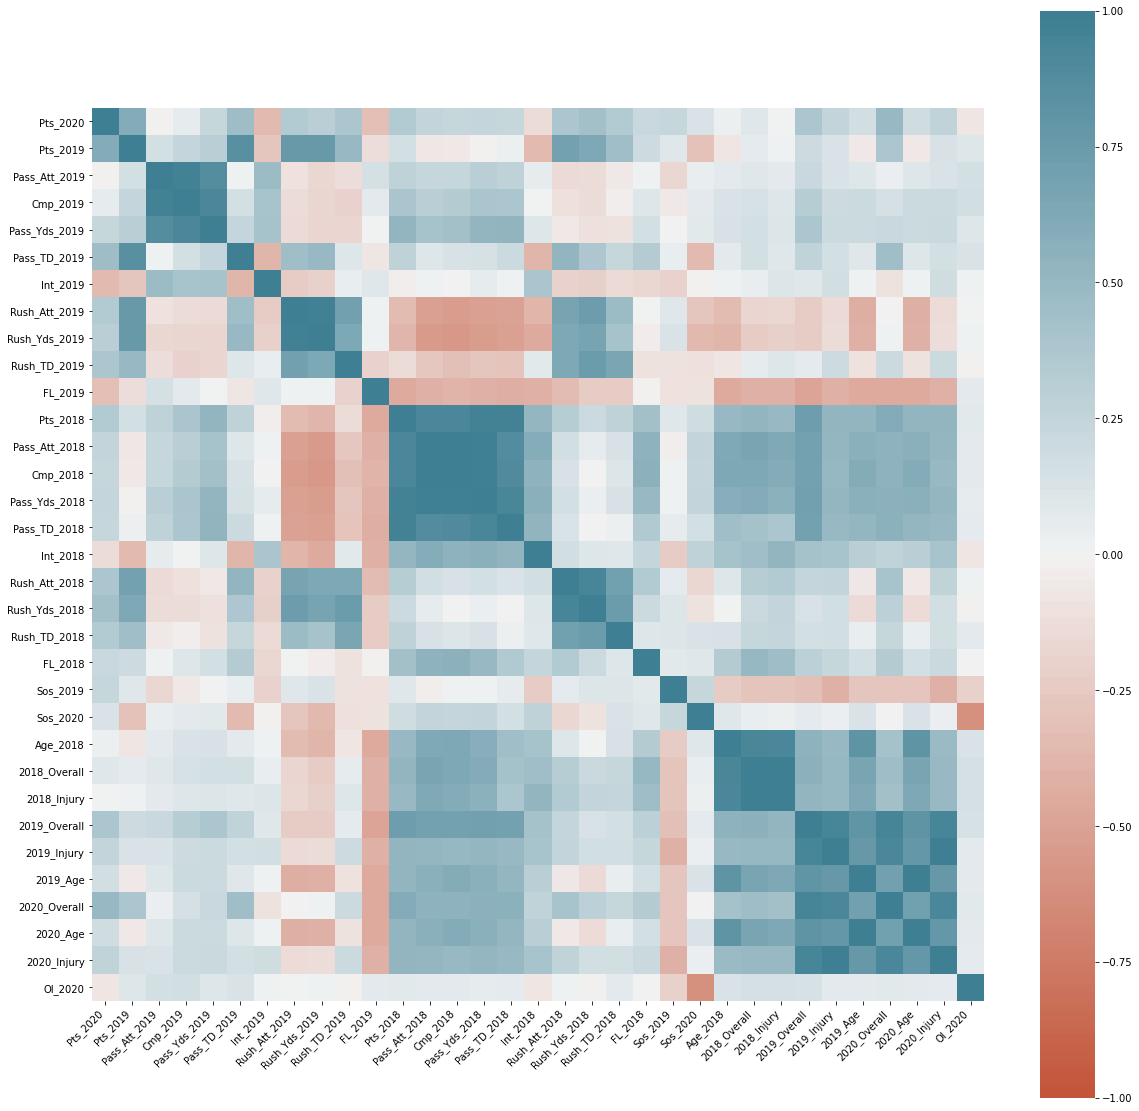

In [ ]:
# Correlation

corr = merged_with_madden_and_ol.corr()
plt.figure(figsize=(20,20))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [ ]:
# Get the training data
train_data = merged_with_madden_and_ol.drop(["Player", "Pts_2020"],axis=1)
target_label = merged_with_madden_and_ol["Pts_2020"]

# Time to optimize the hyperparameters

n_features = train_data.shape[1]
x_train, x_test, y_train, y_test = train_test_split(train_data, target_label, test_size = 0.30)

clf = ensemble.GradientBoostingRegressor(n_estimators=50, random_state=0)

space  = [Integer(1, 15, name='max_depth'),
          Real(10**-5, 10**0, "log-uniform", name='learning_rate'),
          Integer(1, n_features, name='max_features'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

@use_named_args(space)
def objective(**params):
    clf.set_params(**params)

    return -np.mean(cross_val_score(clf, x_train, y_train, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

clf_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

print(clf_gp.fun)
print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (clf_gp.x[0], clf_gp.x[1],
                            clf_gp.x[2], clf_gp.x[3],
                            clf_gp.x[4]))

# Time for fun.


'''
Best parameters:
- max_depth=12
- learning_rate=0.751440
- max_features=9
- min_samples_split=2
- min_samples_leaf=1
0.7291733561459062
'''

clf.fit(x_train, y_train)
clf.score(x_test, y_test)

/root/venv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/root/venv/lib/python3.7/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
85.93333333333334
Best parameters:
- max_depth=15
- learning_rate=1.000000
- max_features=32
- min_samples_split=2
- min_samples_leaf=1


0.5383925040309088

Result: Anywhere between 0.2-0.7

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9d6ab167-ee9b-415e-918f-3bd37d7f66bf' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>